In [1]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



2024-12-30 20:44:45.471704: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2024-12-30 20:44:45.472026: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2024-12-30 20:44:45.472313: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2024-12-30 20:44:45.472584: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cufft64_10.dll'; dlerror: cufft64_10.dll not found
2024-12-30 20:44:45.472859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'curand64_10.dll'; dlerror: curand64_10.dll not found
2024-12-30 20:44:45.473127: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

[]
Num GPUs Available:  0


In [3]:
# Configurar para usar solo la memoria necesaria
# physical_devices = tf.config.list_physical_devices('GPU')
# if physical_devices:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
#     print('done')

In [4]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [5]:
P0_exp=df2.iloc[:, -5:]
P1_exp=df2.iloc[:, 3:9]
P2_exp=df2.iloc[:, 9:14]
P3_exp=df2.iloc[:, [15,19,20]]


P0_exp, P1_exp, P2_exp, P3_exp


(0        H7      H8      H9     H10     H11
 0    0.0921   0.092   0.093  0.0927   0.093
 1    0.0921  0.0921  0.0931  0.0932  0.0925
 2    0.0922  0.0923  0.0932  0.0932  0.0927
 3    0.0928  0.0926  0.0936  0.0937   0.093
 4    0.0933  0.0933  0.0943  0.0944  0.0938
 ..      ...     ...     ...     ...     ...
 337  1.0018  0.9769  0.9848  0.9871  0.9972
 338  1.0017    0.98  0.9857  0.9868  0.9976
 339  1.0009  0.9758  0.9833  0.9846  0.9963
 340  1.0004  0.9763  0.9843  0.9845  0.9981
 341  1.0014  0.9772  0.9853  0.9843  0.9956
 
 [342 rows x 5 columns],
 0        A1      A2      A3      A4      A5      A6
 0    0.0929  0.0971  0.0948  0.0961  0.0939  0.0934
 1    0.0925  0.0962  0.0946  0.0953  0.0935  0.0931
 2    0.0926  0.0962   0.095  0.0954  0.0936  0.0932
 3    0.0928  0.0981  0.0949  0.0956  0.0937  0.0934
 4    0.0933  0.0985  0.0953   0.096  0.0942  0.0939
 ..      ...     ...     ...     ...     ...     ...
 337  0.5954  0.6453  0.6513  0.6593  0.6599  0.6576
 338  0.5

In [6]:
P2_exp.shape

(342, 5)

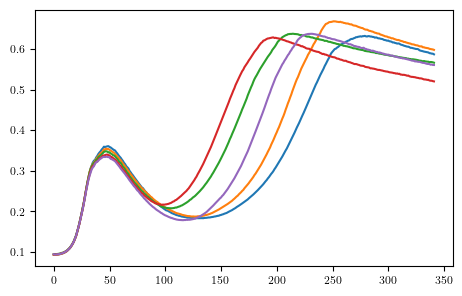

In [7]:
plt.plot(P2_exp)

In [8]:
P1_exp.shape

(342, 6)

In [9]:
c=-1
P_exp=np.array(df2.iloc[:, 9:14])
T_exp=np.array(df2['Time [s]'])

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
N_exp,T_max, T_exp.shape, P_exp.shape

(5, 231399.5, (342,), (342, 5))

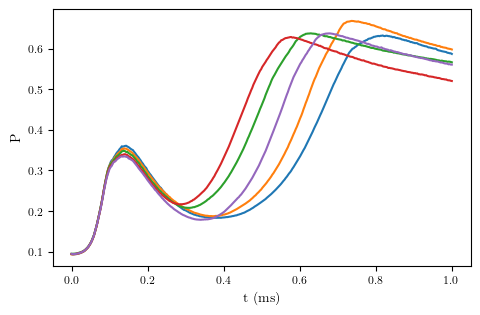

In [10]:
for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

In [11]:
N_f = 1000 # Number of residual point
N_d = 500 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
P0=P_exp[0,:]
T_meshgrid, P0_meshgrid, = np.meshgrid(T_exp, P0)
X_star = np.hstack((T_meshgrid.flatten()[:,None], P0_meshgrid.flatten()[:,None]))
u_star=np.hstack((P_star,P0_meshgrid.flatten()[:,None]))


# T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = X_star.min(0)
lb[1]=lb[1]
ub = X_star.max(0) 
ub[1]=ub[1]


# Initial Condition
xx0 = X_star[::len(T_exp)]
uu0 = P_star[::len(T_exp)]

xx1= np.hstack((np.ones(len(P0)).reshape([-1,1]), P0.reshape([-1,1])))

xx01=np.vstack((xx0, xx1))
uu01=np.array([1]*N_exp+[0]*N_exp).reshape([-1,1])

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu0), replace=False)
xxd = X_star[idx]
uud = P_star[idx]

X_u_train = np.concatenate((xx0,xxd))
P_train = np.concatenate((uu0,uud))

X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
P_train_tf =   tf.convert_to_tensor(P_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)
xx01_tf = tf.convert_to_tensor(xx01, dtype=tf.float32)
uu01_tf = tf.convert_to_tensor(uu01, dtype=tf.float32)

2024-12-30 20:44:46.649034: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


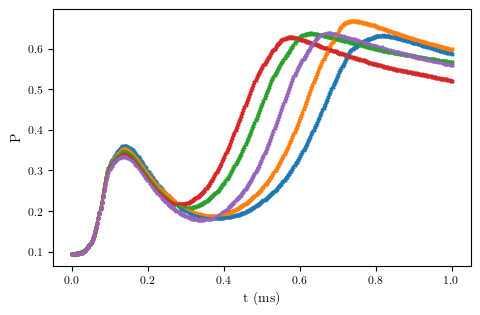

In [12]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.plot(X_star[L_exp*i:L_exp*(i+1)][:,0],P_exp[:, i])
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,0],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

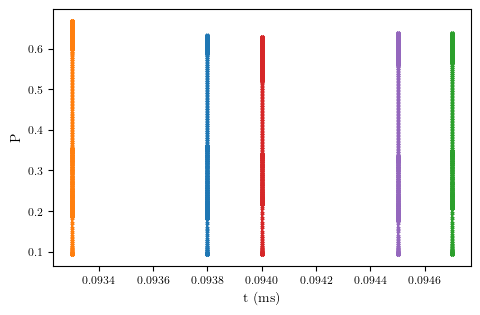

In [13]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.plot(X_star[L_exp*i:L_exp*(i+1)][:,1],P_exp[:, i])
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,1],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

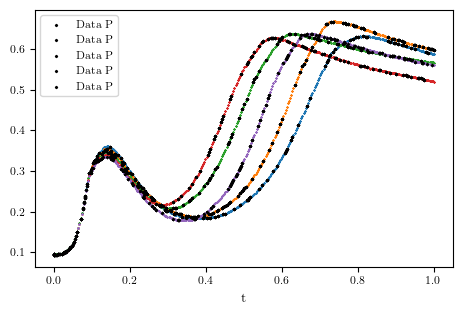

In [14]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,0],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=1)
    plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

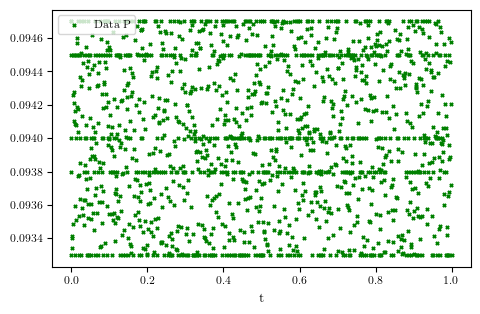

In [15]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,1], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [16]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    # A = 2.0*(X - lb)/(ub - lb) - 1.0
    A=X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 


def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r+N_b, 3]), dtype=tf.float32)
    # alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp*2), (N_exp*2, -1)))
    alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp * 2 * 2), (N_exp * 2, 2))) 
    return alpha_r, alpha_b, alpha_0


#@tf.function(jit_compile=True)
@tf.function()
def net_f(X_f, W_p, b_p,  W_phi_1, b_phi_1, W_phi_2, b_phi_2, lnv):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([X_f])
        u=net(X_f, W_p, b_p)


        lnp1=u[:,0:1]
        lnp2=u[:,1:2]
        lns=u[:,2:3]

        p1=tf.exp(lnp1)
        p2=tf.exp(lnp2)
        s=tf.exp(lns)

        lnphi11=net(s, W_phi_1, b_phi_1)
        phi11=tf.exp(lnphi11)

        phi12=phi11

        lnphi2=net(s, W_phi_2, b_phi_2)
        phi2=tf.exp(lnphi2)

        delta1=tf.exp(lnv[0:1])
        delta2=tf.exp(lnv[1:2])

  
    p1_t = tape1.gradient(p1, X_f)[...,0:1]
    p2_t = tape1.gradient(p2, X_f)[...,0:1]
    s_t = tape1.gradient(s, X_f)[...,0:1]

    f_p1 = p1_t - (phi11*p1 - phi2*p1 -delta1*p1)
    f_p2 = p2_t - (phi12*p2 + phi2*p1 -delta2*p2)
    f_s = s_t - (- phi11*p1 - phi12*p2)
    
    return f_p1, f_p2, f_s




#@tf.function()
# @tf.function()
def train_step(W_p, b_p,  W_phi_1,b_phi_1, W_phi_2, b_phi_2,   X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, opt):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi_1,b_phi_1, W_phi_2, b_phi_2,  lambda_b, lambda_r, lambda_0, lnv])
        u_nn = net(X_u_train_tf, W_p, b_p) 
        lnp1=u_nn[:,0:1]
        lnp2=u_nn[:,1:2]
        p1_nn=tf.exp(lnp1)
        p2_nn=tf.exp(lnp2)
        f_p1, f_p2, f_s = net_f(X_f_train_tf, W_p, b_p, W_phi_1,b_phi_1, W_phi_2, b_phi_2,  lnv)

        u_00 = net(xx01_tf, W_p, b_p) 
      
        p1_00=tf.exp(u_00[:,0:1])
        p2_00=tf.exp(u_00[:,1:2])
        s_00=tf.exp(u_00[:,2:3])


        loss_p = tf.square(lambda_b*(p1_nn+p2_nn - P_train_tf))
        loss_0s = tf.square(lambda_0[:,0:1]*(s_00 - uu01_tf))
        loss_0p1 = tf.square(lambda_0[:N_exp,1:2]*(p1_00[:N_exp] - uu01_tf[N_exp:])) #p1 al principio peque
        loss_0p2 = tf.square(lambda_0[N_exp:,1:2]*(p2_00[:N_exp] - P_train_tf[:N_exp])) #p2 al principio la poblacion
        loss_1p2 = tf.square(lambda_0[N_exp:,1:2]*(p2_00[N_exp:] - uu01_tf[N_exp:])) #p2 al final peque
        loss_fp1 = tf.square(lambda_r[:,0:1]*f_p1) 
        loss_fp2 = tf.square(lambda_r[:,1:2]*f_p2) 
        loss_fs = tf.square(lambda_r[:,2:3]*f_s) 


        # loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp1)+ tf.reduce_mean(loss_fp2)+ tf.reduce_mean(loss_fs)+ tf.reduce_mean(loss_0s)
        # loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp1)+ tf.reduce_mean(loss_fp2)+ tf.reduce_mean(loss_fs)+ tf.reduce_mean(loss_0s)+ tf.reduce_mean(loss_0p1)+ tf.reduce_mean(loss_0p2)
        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp1)+ tf.reduce_mean(loss_fp2)+ tf.reduce_mean(loss_fs)+ tf.reduce_mean(loss_0s)+ tf.reduce_mean(loss_0p1)

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi_1 = tape.gradient(loss, train_vars(W_phi_1, b_phi_1))
    grads_phi_2 = tape.gradient(loss, train_vars(W_phi_2, b_phi_2))

    grads_lnv = tape.gradient(loss, lnv)
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    grads_0 = tape.gradient(loss, lambda_0)

    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi_1, train_vars(W_phi_1, b_phi_1)))
    opt.apply_gradients(zip(grads_phi_2, train_vars(W_phi_2, b_phi_2)))

    opt.apply_gradients(zip([grads_lnv], [lnv]))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    opt.apply_gradients(zip([-grads_0], [lambda_0]))

   
    return loss, tf.reduce_mean(tf.square((p1_nn+p2_nn - P_train_tf))), tf.reduce_mean(tf.square(f_p1)), tf.reduce_mean(tf.square(f_p2)), tf.reduce_mean(tf.square(f_s))


layers = [2, 20, 20, 3]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [1, 20, 20, 1]

W_phi_1 = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi_1 = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [1, 20, 20, 1]
L = len(layers)

W_phi_2 = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi_2 = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lnv = tf.Variable(tf.reshape(tf.repeat(1.0, 2), (2, -1)), dtype=tf.float32) 
lambda_r, lambda_b, lambda_0 = loss_weight(N_f, N_d)



In [17]:
lr = 5e-3




optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/10)
# optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)
# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/40)

# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9, clipnorm=10.0)


start_time = time.time()
it=0
loss = []
loss_d = []
loss_fisp1 = []
loss_fisp2 = []
loss_fiss = []
# loss_reg=[]
# loss_fisa = []

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi_1, b_phi_1,  W_phi_2, b_phi_2, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi_1, b_phi_1,  W_phi_2, b_phi_2, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer2)
# train_step_3 = tf.function(train_dynamic_step).get_concrete_function(W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv, optimizer2)


In [18]:
Nmax=10**5


while it <= Nmax:
    # if it<10**5:
    loss_, loss_p, loss_fp1, loss_fp2, loss_fs = train_step_1(W_p, b_p, W_phi_1, b_phi_1,  W_phi_2, b_phi_2, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    # else:
    #     loss_, loss_p,  loss_fp1, loss_fp2, loss_fs = train_step_2(W_p, b_p, W_phi_1, b_phi_1,  W_phi_2, b_phi_2, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    # else
        # loss_, loss_p,  loss_fp1, loss_fp2, loss_fs = train_step_3(W_phi, b_phi,  W_a, b_a, X_f_train_tf, lambda_r, lnv)

    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp1.append(loss_fp1)
    loss_fisp2.append(loss_fp2)
    loss_fiss.append(loss_fs)
    # loss_fisa.append(loss_fa)



    if it % 10 == 0:

        print(f"Iteration is: {it}")
        # print(f"Total loss is: {loss_}")
        # print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p1 is: {loss_fp1}")
        print(f"Physicial loss of p2 is: {loss_fp2}")
        print(f"Physicial loss of s is: {loss_fs}")
        # if n%10000 ==0:
        #     loss_reg_=eval(W_p, b_p, W_phi_s, b_phi_s)
        #     loss_reg.append(loss_reg_)
        # print(f"Physicial loss of a is: {loss_fa}")

    it+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Physicial loss of p1 is: 8.171622276306152
Physicial loss of p2 is: 0.04197930172085762
Physicial loss of s is: 2.6099648475646973
Iteration is: 10
Physicial loss of p1 is: 0.15232616662979126
Physicial loss of p2 is: 0.0024724574759602547
Physicial loss of s is: 0.017936641350388527
Iteration is: 20
Physicial loss of p1 is: 0.005235414486378431
Physicial loss of p2 is: 0.049168914556503296
Physicial loss of s is: 0.20955485105514526
Iteration is: 30
Physicial loss of p1 is: 0.014830117113888264
Physicial loss of p2 is: 0.4337098300457001
Physicial loss of s is: 0.18753011524677277
Iteration is: 40
Physicial loss of p1 is: 0.003994124010205269
Physicial loss of p2 is: 0.349045991897583
Physicial loss of s is: 0.3757283389568329
Iteration is: 50
Physicial loss of p1 is: 0.0012860707938671112
Physicial loss of p2 is: 0.14960184693336487
Physicial loss of s is: 0.30340373516082764
Iteration is: 60
Physicial loss of p1 is: 0.0017660567536950111
Physicial loss of p2 is: 0.26

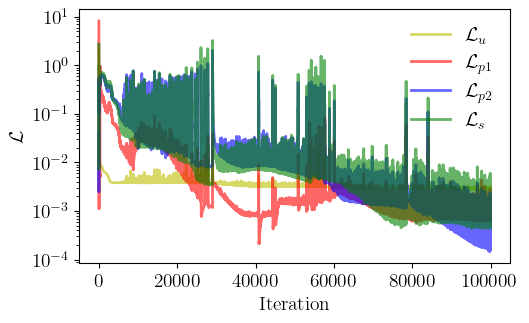

In [ ]:
Nmax=len(loss)
ep = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]

loss_phip1_list = [loss_fisp1[i].numpy() for i in range(0,Nmax)]
loss_phip2_list = [loss_fisp2[i].numpy() for i in range(0,Nmax)]
loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]



plt.semilogy(ep, np.asarray(loss_data_list), 'y-', linewidth = 2, alpha=0.6, label = '$\mathcal{L}_u$')  
plt.semilogy(ep, np.asarray(loss_phip1_list), 'r-', linewidth = 2, alpha=0.6, label = '$\mathcal{L}_{p1}$') 
plt.semilogy(ep, np.asarray(loss_phip2_list), 'b-', linewidth = 2, alpha=0.6, label = '$\mathcal{L}_{p2}$')    
plt.semilogy(ep, np.asarray(loss_phis_list), 'g-', linewidth = 2, alpha=0.6, label = '$\mathcal{L}_s$')       



plt.legend(fontsize=14, ncols=1, frameon=False)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\mathcal{L}$', fontsize=14)    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/Nooop/Loss_split.png')
plt.savefig('../Img/Nooop/Loss_split.pdf')
plt.savefig('../Img/Nooop/Loss_split.svg')
plt.show()

In [20]:
lnv[0], tf.exp(lnv[0]), lnv[1], tf.exp(lnv[1])#, lnv[2], tf.exp(lnv[2])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-27.26667], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.4395793e-12], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.2187498], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([9.195827], dtype=float32)>)

In [21]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)  
# A_star_tf = tf.convert_to_tensor(A, dtype=tf.float32)    

u_pred = predict(X_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp1=u_pred[:,0:1]
lnp2=u_pred[:,1:2]
lns=u_pred[:,2:3]

p1=tf.exp(lnp1)
p2=tf.exp(lnp2)
s=tf.exp(lns)

delta1=tf.exp(lnv[0:1])
delta2=tf.exp(lnv[1:2])


# lnphi11 = predict(tf.concat([p1, s],1), W_phi_1, b_phi_1)
# lnphi12 = predict(tf.concat([p2, s],1), W_phi_1, b_phi_1)

lnphi11 = predict(s, W_phi_1, b_phi_1)
lnphi12=lnphi11
lnphi2 = predict(s, W_phi_2, b_phi_2)

phi11=tf.exp(lnphi11)
phi12=tf.exp(lnphi12)
phi2=tf.exp(lnphi2)




In [22]:
X_star_tf.shape, p1.shape

(TensorShape([1710, 2]), TensorShape([1710, 1]))

In [94]:
colors = plt.cm.tab20.colors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


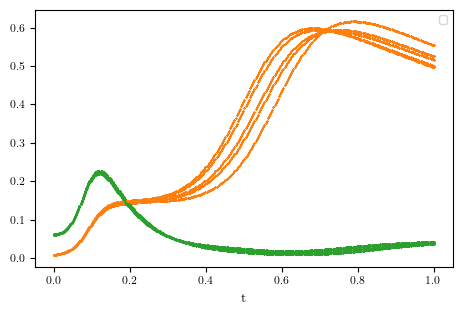

In [95]:
for i in range(N_exp):
    plt.scatter(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p1[L_exp*i:L_exp*(i+1)], marker='x', s=1, color=colors[2])
    plt.scatter(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p2[L_exp*i:L_exp*(i+1)], marker='x', s=1,  color=colors[4])
    # plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

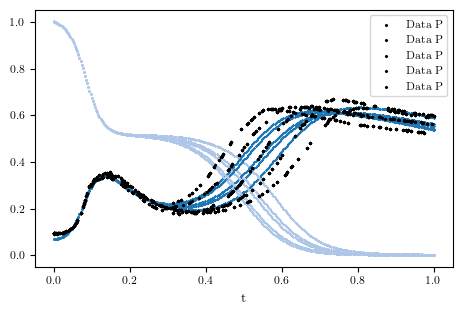

In [96]:
for i in range(N_exp):
    plt.scatter(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], (p1+p2)[L_exp*i:L_exp*(i+1)], marker='x', s=1, color=colors[0])
    plt.scatter(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], marker='x', s=1, color=colors[1])
    plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

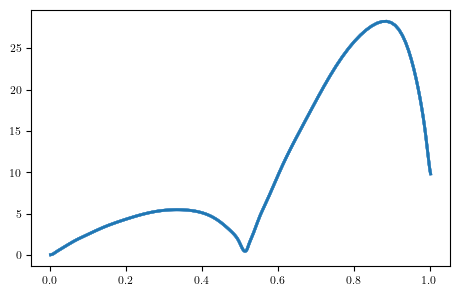

In [97]:
for i in range(1, N_exp):
    # plt.plot(p[L_exp*i:L_exp*(i+1)][:,0], phi[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
    plt.plot(s[L_exp*i:L_exp*(i+1)][:,0], phi11[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])
    plt.plot(s[L_exp*i:L_exp*(i+1)][:,0], phi12[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


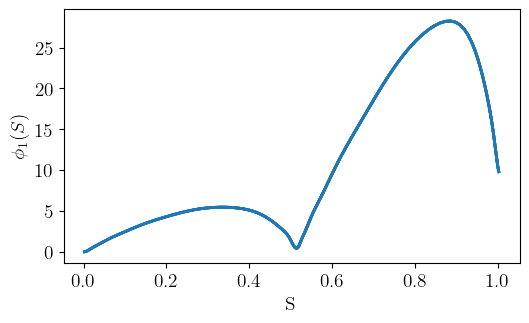

In [98]:

for i in range(0, N_exp):
    plt.plot(s[L_exp*i:L_exp*(i+1)][:,0], phi11[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])

# plt.plot(p, phi,linewidth=3)
# plt.plot(s, phi, linewidth=3)
# plt.scatter(X_f_train_tf, np.zeros_like(X_f_train), marker='x', s=5, color='green',label='$f$')

# plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel('S', fontsize=14)

plt.ylabel('$\phi_1(S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/Nooop/Result_phi_1.png')
plt.savefig('../Img/Nooop/Result_phi_1.pdf')
plt.savefig('../Img/Nooop/Result_phi_1.svg')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


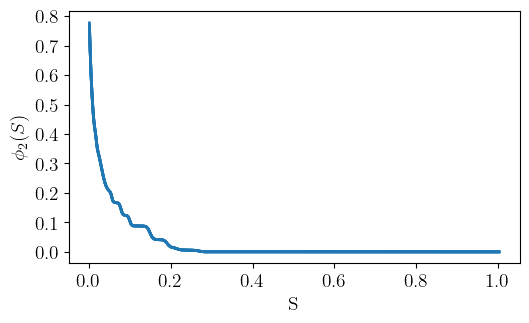

In [ ]:

for i in range(0, N_exp):
    plt.plot(s[L_exp*i:L_exp*(i+1)][:,0], phi2[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])

# plt.plot(p, phi,linewidth=3)
# plt.plot(s, phi, linewidth=3)
# plt.scatter(X_f_train_tf, np.zeros_like(X_f_train), marker='x', s=5, color='green',label='$f$')

# plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel('S', fontsize=14)

plt.ylabel('$\phi_2(S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/Nooop/Result_phi_2.png')
plt.savefig('../Img/Nooop/Result_phi_2.pdf')
plt.savefig('../Img/Nooop/Result_phi_2.svg')
plt.show()

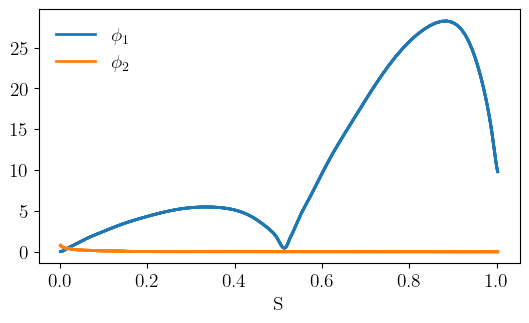

In [ ]:
plt.plot(s[L_exp*i:L_exp*(i+1)][:,0], phi11[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0], label=r'$\phi_1$')

for i in range(1, N_exp):
    plt.plot(s[L_exp*i:L_exp*(i+1)][:,0], phi11[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])


plt.plot(s[L_exp*i:L_exp*(i+1)][:,0], phi2[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[2], label=r'$\phi_2$')

for i in range(1, N_exp):
    plt.plot(s[L_exp*i:L_exp*(i+1)][:,0], phi2[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[2])

# plt.plot(p, phi,linewidth=3)
# plt.plot(s, phi, linewidth=3)
# plt.scatter(X_f_train_tf, np.zeros_like(X_f_train), marker='x', s=5, color='green',label='$f$')

# plt.legend(fontsize=14, ncols=1, frameon=False,  bbox_to_anchor=(1, 0.7))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel('S', fontsize=14)

# plt.ylabel('$\phi_2(S)$', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/Nooop/Result_phi.png')
plt.savefig('../Img/Nooop/Result_phi.pdf')
plt.savefig('../Img/Nooop/Result_phi.svg')
plt.show()

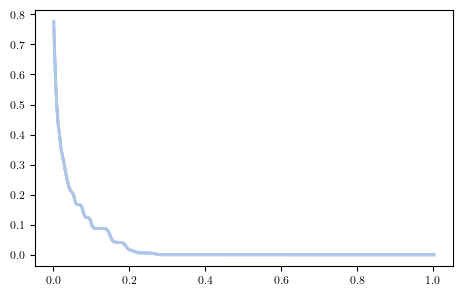

In [102]:
for i in range(1, N_exp):
    # plt.plot(p[L_exp*i:L_exp*(i+1)][:,0], phi[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[0])
    plt.plot(s[L_exp*i:L_exp*(i+1)][:,0], phi2[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])


In [71]:
p2[::L_exp]


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.06110286],
       [0.06153246],
       [0.06027537],
       [0.0609249 ],
       [0.06046508]], dtype=float32)>

In [72]:
p1[::L_exp]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.00796731],
       [0.00790597],
       [0.00808419],
       [0.00799256],
       [0.00805748]], dtype=float32)>

In [73]:
Nt=1000
T_int=np.zeros(Nt)
P1_int=np.zeros(Nt)
P2_int=np.zeros(Nt)
S_int=np.zeros(Nt)


dt=0.001

T_int[0]=0
P1_int[0]=np.array(p1[0]+0.00025) #Initial conditions

P2_int[0]=np.array(p2[0]) #Initial conditions
S_int[0]=np.array(s[0]) #Initial conditions


# m=0.3

for i in range(1,Nt):

    S_int_tf= tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32)
    PHI11=tf.exp(predict(S_int_tf , W_phi_1, b_phi_1))
    PHI12=PHI11
    PHI2=tf.exp(predict( S_int_tf, W_phi_2, b_phi_2))

    # P1_int[i]=P1_int[i-1]+(PHI11*S_int[i-1]*P1_int[i-1] - PHI2*P1_int[i-1]-delta1*P1_int[i-1])*dt
    # P2_int[i]=P2_int[i-1]+(PHI12*S_int[i-1]*P2_int[i-1] + PHI2*P1_int[i-1]-delta2*P2_int[i-1])*dt

    
    P1_int[i]=P1_int[i-1]+(PHI11*P1_int[i-1] - PHI2*P1_int[i-1]-delta1*P1_int[i-1])*dt
    P2_int[i]=P2_int[i-1]+(PHI12*P2_int[i-1] + PHI2*P1_int[i-1]-delta2*P2_int[i-1])*dt

    S_int[i]=S_int[i-1]-(PHI11*P1_int[i-1]+PHI12*P2_int[i-1])*dt
    T_int[i]=T_int[i-1]+dt

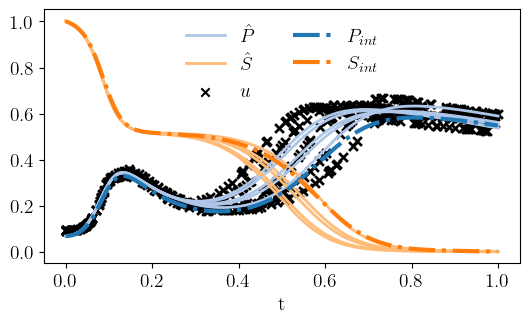

In [ ]:
i=0
plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], (p1+p2)[L_exp*i:L_exp*(i+1)], color=colors[1], linestyle='-',linewidth=2, label='$\hat{P}$')
plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], color=colors[3], linestyle='-',linewidth=2, label='$\hat{S}$')

plt.scatter(X_u_train[:,0], P_train, marker='x', color='black',label='$u$')
for i in range(1, N_exp):
    plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], (p1+p2)[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[1])
    plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[3])

    plt.scatter(X_u_train[:,0], P_train, marker='x',  color='black')

plt.plot(T_int, P1_int+P2_int, linestyle='-.',linewidth=3, color=colors[0], label='$P_{int}$')
plt.plot(T_int, S_int, linestyle='-.',linewidth=3, color=colors[2], label='$S_{int}$')
# plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
# plt.legend(fontsize=12, ncols=1, frameon=False,  bbox_to_anchor=(0.7, 0.4))
plt.legend(fontsize=14, ncols=2, frameon=False)

plt.xlabel('t', fontsize=14)
# plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/Nooop/Result_int.png')
plt.savefig('../Img/Nooop/Result_int.pdf')
plt.savefig('../Img/Nooop/Result_int.svg')
plt.show()

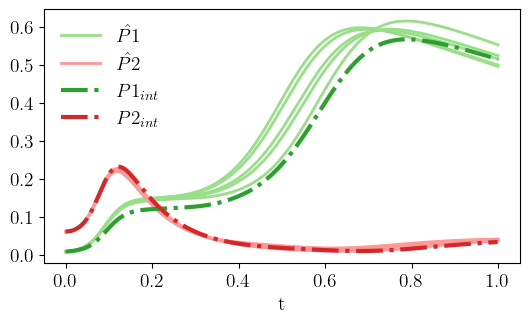

In [108]:
i=0
plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p1[L_exp*i:L_exp*(i+1)],  color=colors[5], linestyle='-',linewidth=2, label='$\hat{P1}$')
plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p2[L_exp*i:L_exp*(i+1)],  color=colors[7], linestyle='-',linewidth=2, label='$\hat{P2}$')

# plt.scatter(X_u_train[:,0], P_train, marker='x', color='black',label='$u$')
for i in range(1, N_exp):
    plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p1[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[5])
    plt.plot(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p2[L_exp*i:L_exp*(i+1)], linestyle='-',linewidth=2,  color=colors[7])

    # plt.scatter(X_u_train[:,0], P_train, marker='x',  color='black')

plt.plot(T_int, P1_int, linestyle='-.',linewidth=3, color=colors[4], label='$P1_{int}$')
plt.plot(T_int, P2_int, linestyle='-.',linewidth=3, color=colors[6], label='$P2_{int}$')
# plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
# plt.legend(fontsize=12, ncols=1, frameon=False,  bbox_to_anchor=(0.7, 0.4))
plt.legend(fontsize=14, ncols=1, frameon=False)

plt.xlabel('t', fontsize=14)
# plt.ylabel('P', fontsize=14)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.tight_layout()
plt.savefig('../Img/Nooop/Result_int_2.png')
plt.savefig('../Img/Nooop/Result_int_2.pdf')
plt.savefig('../Img/Nooop/Result_int_2.svg')
plt.show()